Nome dos integrantes e RM:
Razyel Ferrari rm551875
Rayzor Anael rm551832
Derick Araújo rm551007
Kalel Schlichting rm550620
Phablo santos rm550687

DATASET DAS IMAGENS:https://www.kaggle.com/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/data

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import os
import zipfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def mostrar_evolucao_acerto(history):

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Categorical Crossentropy')
    ax1.plot(hist['epoch'], hist['loss'], label='Train Error')
    ax1.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    ax1.grid()
    ax1.legend()

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    ax2.plot(hist['epoch'], hist['val_accuracy'], label = 'Val Accuracy')
    ax2.grid()
    ax2.legend()

    plt.show()

In [ ]:
import os

# arquivo do dataset
dataset_path = "/content/drive/MyDrive/arquivos para GS/"

# LISTA DE ARCHIVOS EN EL DIRECTORIO
file_list = os.listdir(dataset_path)

# IMPRIMIMOS EL NOMBRE DE LOS ARCHIVOS
for file_name in file_list:
    print(file_name)

The IQ-OTHNCCD lung cancer dataset
Test
.ipynb_checkpoints


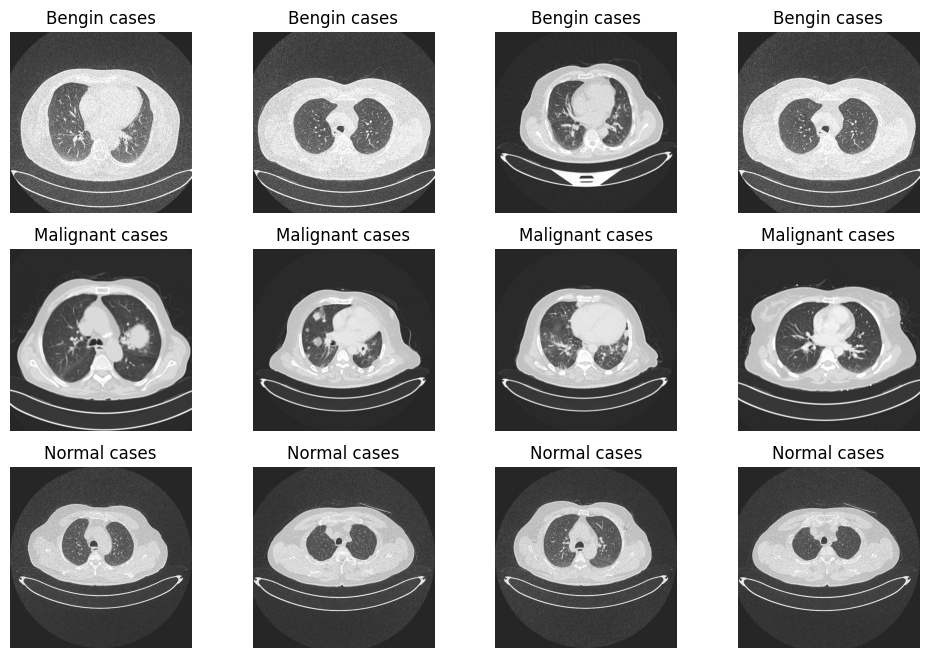

In [ ]:
import cv2

directory = "/content/drive/MyDrive/arquivos para GS/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/"
directory_test = "/content/drive/MyDrive/arquivos para GS/Test"
cases = ['Bengin cases', 'Malignant cases', 'Normal cases']

fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))

for index, case in enumerate(cases):
    img_list = os.listdir(os.path.join(directory, case))
    for i in range(4):
        img = cv2.imread(os.path.join(directory, case, img_list[i]))
        ax[index, i].imshow(img)
        ax[index, i].axis('off')
        ax[index, i].set_title(case)

plt.show()

In [ ]:
#redimensionando as imagens para ficar do tamanho padrao
import imageio

size_data = {}
for i in cases:
    path = os.path.join(directory, i)
    class_num = cases.index(i)
    temp_dict = {}
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = imageio.imread(filepath).shape
        if str(height) + ' x ' + str(width) in temp_dict:
            temp_dict[str(height) + ' x ' + str(width)] += 1
        else:
            temp_dict[str(height) + ' x ' + str(width)] = 1

    size_data[i] = temp_dict

size_data

<ipython-input-7-b2a62c84332f>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  height, width, channels = imageio.imread(filepath).shape


{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 512': 501,
  '512 x 801': 28,
  '404 x 511': 1,
  '512 x 623': 31},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_width, img_height = 224, 224
batch_size = 32

datagen= ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    vertical_flip=False)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
training_data = datagen.flow_from_directory(
        directory,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        subset='training',
        shuffle=True,
        classes=['Bengin cases', 'Malignant cases', 'Normal cases'])

validation_generator = datagen.flow_from_directory(
        directory,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        subset='validation',
        shuffle=True,
        classes=['Bengin cases', 'Malignant cases', 'Normal cases'])

test_data = test_datagen.flow_from_directory(
    directory_test,
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode=None,
    shuffle=False)

Found 878 images belonging to 3 classes.
Found 219 images belonging to 3 classes.
Found 197 images belonging to 1 classes.


In [ ]:
class_indices = training_data.class_indices
class_counts = {class_name: 0 for class_name in class_indices}

for class_name in class_indices:
    class_dir = os.path.join(directory, class_name)
    num_images = len(os.listdir(class_dir))
    class_counts[class_name] = num_images

print("contar as imagens por classe:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} imagens")

contar as imagens por classe:
Bengin cases: 120 imagens
Malignant cases: 561 imagens
Normal cases: 416 imagens


In [ ]:
print(training_data.class_indices)
print(validation_generator.class_indices)

{'Bengin cases': 0, 'Malignant cases': 1, 'Normal cases': 2}
{'Bengin cases': 0, 'Malignant cases': 1, 'Normal cases': 2}


In [ ]:
from tensorflow.keras.applications import VGG16

#Carregar o modelo pré-treinado VGG16 sem as camadas totalmente conectadas (incluindo o classificador)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

#Congelar todas as camadas do modelo base (transferir aprendizagem)
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 2s 0us/step


Sabendo a quantidade de imagens por classe, vamos reequilibrar os pesos, pois podemos perceber que na classe “Casos Bengin” temos muito menos imagens do que nas demais

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#Criamos um dicionário reverso de índices de classe
inverse_class_indices = {v: k for k, v in training_data.class_indices.items()}

#Obtemos a contagem das classes
class_counts = [120, 561, 416]

#Calcule os pesos das classes inversamente proporcionais às contagens
class_weights = compute_class_weight('balanced', classes=np.unique(training_data.classes), y=training_data.classes)
class_weights_dict = {idx: weight for idx, weight in enumerate(class_weights)}

#Imprimir pesos de classe ajustados
print("Pesos de classe ajustados:")
for idx, weight in class_weights_dict.items():
    class_name = inverse_class_indices[idx]
    print(f"{class_name}: {weight:.2f}")

Pesos de classe ajustados:
Bengin cases: 3.05
Malignant cases: 0.65
Normal cases: 0.88


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPooling2D, Conv2D

model_CW = Sequential()
model_CW.add(base_model)

model_CW.add(Conv2D(64, 3, activation='relu', padding = 'valid', input_shape=(img_width, img_height, 3)))
model_CW.add(MaxPooling2D((2, 2)))
model_CW.add(Dropout(0.4))

model_CW.add(Conv2D(128, 3, activation='relu', padding = 'same'))
model_CW.add(MaxPooling2D((2, 2)))
model_CW.add(Dropout(0.4))

model_CW.add(Flatten())
model_CW.add(Dropout(0.3))

model_CW.add(Dense(256, activation='relu'))
model_CW.add(Dropout(0.5))

model_CW.add(Dense(3, activation='softmax'))

class_weights = {
    0: 3.05,  # Clase 0 (Bengin cases)
    1: 0.65,  # Clase 1 (Malignant cases)
    2: 0.88  # Clase 2 (Normal cases)
}

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
model_CW.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_CW.fit(
    training_data,
    steps_per_epoch = training_data.n//training_data.batch_size,
    validation_steps = validation_generator.n//validation_generator.batch_size,
    epochs=70,
    validation_data=validation_generator,
    validation_split = 0.2,
    shuffle = True,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/70
27/27 [==============================] - 33s 784ms/step - loss: 1.1743 - accuracy: 0.3889 - val_loss: 1.0773 - val_accuracy: 0.5417
Epoch 2/70
27/27 [==============================] - 23s 863ms/step - loss: 1.0751 - accuracy: 0.4161 - val_loss: 1.0460 - val_accuracy: 0.5365
Epoch 3/70
27/27 [==============================] - 20s 759ms/step - loss: 0.9779 - accuracy: 0.5721 - val_loss: 0.8723 - val_accuracy: 0.5729
Epoch 4/70
27/27 [==============================] - 22s 812ms/step - loss: 0.8916 - accuracy: 0.5839 - val_loss: 0.6798 - val_accuracy: 0.6510
Epoch 5/70
27/27 [==============================] - 22s 795ms/step - loss: 0.8033 - accuracy: 0.6726 - val_loss: 0.6547 - val_accuracy: 0.7500
Epoch 6/70
27/27 [==============================] - 22s 805ms/step - loss: 0.7240 - accuracy: 0.7009 - val_loss: 0.6852 - val_accuracy: 0.6250
Epoch 7/70
27/27 [==============================] - 22s 804ms/step - loss: 0.6873 - accuracy: 0.6962 - val_loss: 0.6641 - val_accuracy: 0.6094

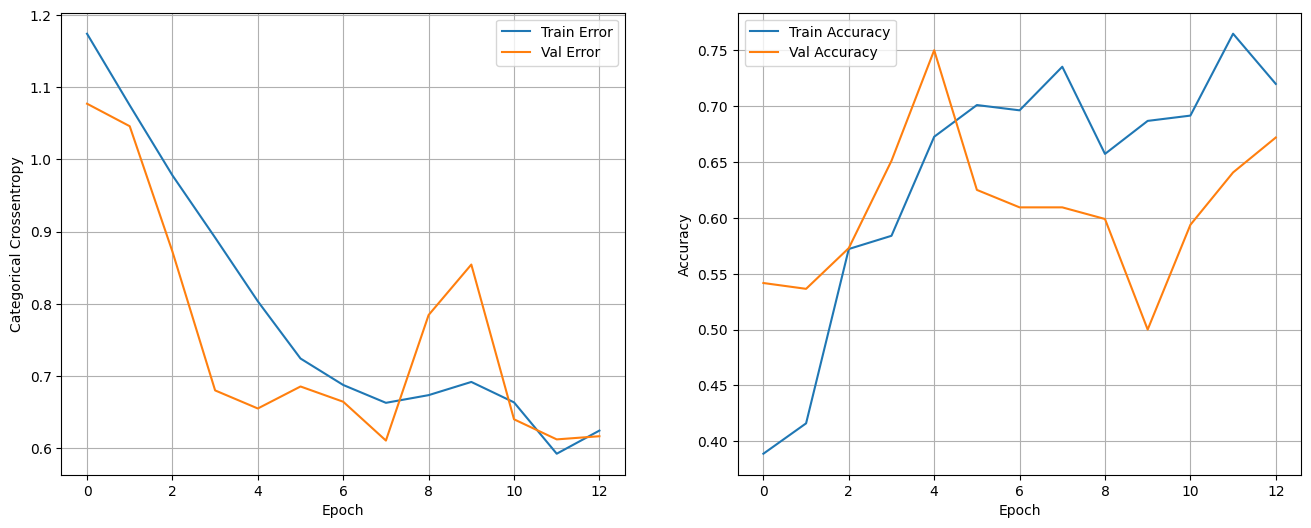

In [ ]:
mostrar_evolucao_acerto(history)


In [ ]:
results = model_CW.evaluate(validation_generator, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.58672696352005
Test Accuracy: 0.6575342416763306


In [ ]:
model_CW.save("/content/drive/My Drive/modelo_detect_cancer_pulmao.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


(224, 224, 3)
1/1 [==============================] - 1s 1s/step


array([[2.6007056e-01, 4.5741582e-18, 7.3992944e-01]], dtype=float32)

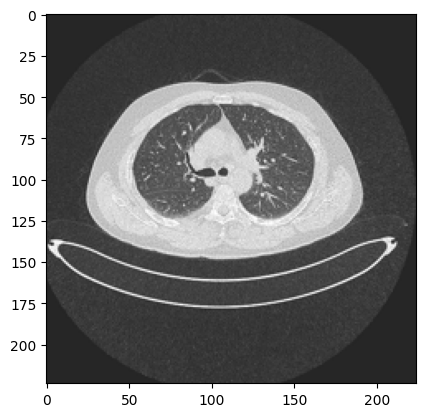

In [ ]:
#Predicao
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import keras

model = keras.models.load_model("/content/drive/My Drive/modelo_detect_cancer_pulmao.h5")
%matplotlib inline

pil_im = Image.open('/content/drive/MyDrive/arquivos para GS/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (106).jpg', 'r')
im = np.asarray(pil_im.resize((224, 224)))
imshow(im)
print(im.shape)
im = im.reshape(1,224,224,3)
model.predict(im)

In [ ]:
# Realizar a predição
predictions = model.predict(im)

# Obter o indice da classe com a maior probabilidade
predicted_class_index = np.argmax(predictions)

# Mapear o indice da classe
class_names = ["Bengin", "Malignant", "Normal"]
predicted_class_name = class_names[predicted_class_index]

# Imprimir a classe predicta
print("Classe prevista:", predicted_class_name)

1/1 [==============================] - 0s 18ms/step
Classe prevista: Normal


In [ ]:
predict = model_CW.predict_generator(test_data)

#mostrar a previsao do test_data
y_classes = predict.argmax(axis=-1)

<ipython-input-21-c14455315535>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model_CW.predict_generator(test_data)


In [ ]:
print(y_classes)

[1 1 1 1 1 0 0 0 2 2 0 0 2 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 2 0 2 2
 1 0 0 0 0 2 0 2 0 0 2 2 2 1 0 2 1 1 2 1 1 2 2 2 1 1 2 1 1 1 0 0 1 0 0 0 0
 2 0 0 0 2 1 0 2 0 0 0 2 2 1 1 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 1 1 2 1 2 0 2
 0 2 0 0 0 0 0 2 0 2 2 0 0 1 0 2 0 1 2 2 2 2 2 2 2 0 2 2 1 2 2 0 2 2 2 0 0
 0 1 0 1 0 0 0 2 0 2 2 0 2 1 0 2 0 0 0 0 0 1 2 0 2 0 1 2 2 0 2 2 2 0 1 1 2
 0 2 1 2 2 0 0 1 1 0 1 2]


In [ ]:
from tensorflow.keras.preprocessing import image

prediction_img = ["/content/drive/MyDrive/arquivos para GS/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (10).jpg",
                  "/content/drive/MyDrive/arquivos para GS/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Malignant cases/Malignant case (14).jpg",
                  "/content/drive/MyDrive/arquivos para GS/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases/Normal case (105).jpg"]

In [ ]:
for i in prediction_img:
    img = image.load_img(i, target_size=(img_width, img_height))
    img_arr = image.img_to_array(img)
    img_arr= np.expand_dims(img_arr, axis=0)
    img_arr= img_arr/255
    predictions = model_CW.predict(img_arr)
    predicted_class = np.argmax(predictions)
    probabilidad = np.max(predictions)
    if predicted_class == 0:
        print('Benign')
        print(probabilidad)
    elif predicted_class == 1:
        print('Malignant')
        print(probabilidad)
    else:
        print('Normal')
        print(probabilidad)

1/1 [==============================] - 0s 19ms/step
Benign
0.4942781
1/1 [==============================] - 0s 17ms/step
Malignant
0.99618953
1/1 [==============================] - 0s 18ms/step
Normal
0.60587716
